In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
from tqdm import tqdm
import seaborn
import torch
import torch.nn as nn
BILICOUGH_ROOT = "G:/DATAS-Medical/BILIBILICOUGH/"

# 从mp4中提取wav音频

In [13]:
names = ["金_属_音_咳_嗽","剧烈的咳嗽。","女孩感冒哮喘发作","四个常见咳嗽声音最后一个要重视_听一下你属于哪一种","我咳嗽的样子", "小朋友哮喘发作（看着好痛苦）"]
for name in names:
    filename = BILICOUGH_ROOT + name + ".mp4"
    outname = BILICOUGH_ROOT + name + ".wav"
    os.system("ffmpeg -i {} -f wav -ar 44100 {}".format(filename, outname))

In [ ]:
file_list = []
for item in os.listdir(BILICOUGH_ROOT):
    if item[-3:] == "ass":
        file_list.append(item)
name_mapper = open(BILICOUGH_ROOT + "filename2index.txt", 'w')
for idx, item in enumerate(file_list):
    print(BILICOUGH_ROOT+item)
    name_mapper.write("bilicough_{},".format(("00"+str(idx))[-3:])+item[:-4]+"\n")
name_mapper.close()

# 读取整个音频并标注其咳嗽段

In [2]:
wavfin = open(BILICOUGH_ROOT + "filename2index.txt", 'r')
name_list = []
wavfin.readline()
line = wavfin.readline()
while line:
    name_list.append(line.strip())
    line = wavfin.readline()
print(name_list)

['bilicough_000', 'bilicough_001', 'bilicough_002', 'bilicough_003', 'bilicough_004', 'bilicough_005', 'bilicough_006', 'bilicough_007', 'bilicough_008', 'bilicough_009', 'bilicough_010', 'bilicough_011', 'bilicough_012', 'bilicough_013', 'bilicough_014', 'bilicough_015', 'bilicough_016', 'bilicough_017', 'bilicough_018']


In [3]:
def min2sec(t: str):
    parts = t.split(':')
    res = float(parts[-1])
    f = 60
    for i in range(len(parts)-1):
        res += int(parts[len(parts)-2-i]) * f
        f *= 60
    return res

def wav_plot(wavfile, label_list, idx=0):
    y, sr = librosa.load(BILICOUGH_ROOT + wavfile)
    print("sample rate:", sr)
    y_plt = np.array([])
    for item in label_list:
        st, en = int(min2sec(item[0])*sr), int(min2sec(item[1])*sr+1)
        print("st, en:", st, en)
        seg = y[st: en]
        y_plt = np.concatenate((y_plt, seg, np.zeros(8000)), axis=0)
    plt.figure(idx)
    plt.plot(y_plt)

In [ ]:
idx = 17
wavtest = name_list[idx] + ".wav"
asstest = name_list[idx] + ".ass"
print(wavtest, asstest)
assfin = open(BILICOUGH_ROOT + asstest, 'r', encoding="utf-8")
label_list = []
line = assfin.readline()
while line.strip()!="[Events]":
    line = assfin.readline()
    # print(line)
assfin.readline()
line = assfin.readline()
while line:
    # print(line)
    parts = line.split(',')
    if parts[9].strip() == "useless":
        pass
    else:
        label_list.append([parts[1], parts[2], parts[9].strip()])
    line = assfin.readline()
for item in label_list:
    print(item)
wav_plot(wavtest, label_list, idx)

### 批量绘图

In [ ]:
for idx, name in enumerate(name_list):
    wavtest = name_list[idx] + ".wav"
    asstest = name_list[idx] + ".ass"

    assfin = open(BILICOUGH_ROOT + asstest, 'r', encoding="utf-8")
    label_list = []
    line = assfin.readline()
    while line.strip()!="[Events]":
        line = assfin.readline()
        # print(line)
    assfin.readline()
    line = assfin.readline()
    while line:
        # print(line)
        parts = line.split(',')
        if parts[9].strip() == "useless":
            pass
        else:
            label_list.append([parts[1], parts[2], parts[9].strip()])
        line = assfin.readline()
    for item in label_list:
        print(item)
    
    wav_plot(wavtest, label_list, idx)

# 二分类及其标注
- 非咳嗽的标注：0，"useless", "silence", "noise"
- 咳嗽的标注：1，其他都是

### 第一步，读取所有的ass文件
- 查看标签有哪些，来自哪些文件
- 查看标签的个数
- 查看时长分布

In [1]:
wavfin = open("G:/DATAS-Medical/BILIBILICOUGH/filename2index.txt", 'r')
name_list = []
wavfin.readline()
line = wavfin.readline()
while line:
    name_list.append(line.strip())
    line = wavfin.readline()
print(name_list)

['bilicough_000', 'bilicough_001', 'bilicough_002', 'bilicough_003', 'bilicough_004', 'bilicough_005', 'bilicough_006', 'bilicough_007', 'bilicough_008', 'bilicough_009', 'bilicough_010', 'bilicough_011', 'bilicough_012', 'bilicough_013', 'bilicough_014', 'bilicough_015', 'bilicough_016', 'bilicough_017', 'bilicough_018']


### 注意！此处有重要文件“bilicough_metainfo.csv”的创建和写入

In [5]:
print(name_list)
label_dict = dict()
label_names = ["breathe", "cough","clearthroat","exhale", "hum", "inhale","noise", "silence", "sniff","speech", "vomit","whooping"]
label_cnt = dict()
name2label = {"breathe":0, "cough":2,"clearthroat":1,"exhale":3, "hum":4, "inhale":5,"noise":6, "silence":7, "sniff":8,"speech":9, "vomit":10,"whooping":11}
# metainfo_file = open("G:/DATAS-Medical/BILIBILICOUGH/bilicough_metainfo.csv", 'w')
# metainfo_file.write("filename,st,en,labelfull,labelname,label\n")
for idx, name in enumerate(name_list):
    wavtest = name_list[idx] + ".wav"
    asstest = name_list[idx] + ".ass"
    assfin = open("G:/DATAS-Medical/BILIBILICOUGH/" + asstest, 'r', encoding="utf-8")
    label_list = []
    line = assfin.readline()
    while line.strip()!="[Events]":
        line = assfin.readline()
        # print(line)
    assfin.readline()
    line = assfin.readline()
    while line:
        # print(line)
        parts = line.split(',')
        lab_tmp = parts[9].strip()
        if lab_tmp == "useless":
            pass
        # if lab_tmp == "clearingthroat":
        #     print(name_list[idx])
        else:
            label_list.append([parts[1], parts[2], lab_tmp])
            if lab_tmp not in label_dict:
                label_dict[lab_tmp] = 1
            else:
                label_dict[lab_tmp] = label_dict.get(lab_tmp)+1
            
            label = None
            if lab_tmp[:3] == "hum":
                label = lab_tmp[:3]
            elif lab_tmp[:5] in ["cough", "noise", "sniff", "vomit"]:
                label = lab_tmp[:5]
            elif lab_tmp[:6] in ["inhale", "exhale", "speech"]:
                label = lab_tmp[:6]
            elif lab_tmp[:7] in ["breathe","silence"]:
                label = lab_tmp[:7]
            elif lab_tmp[:8] in ["whooping"]:
                label = lab_tmp[:8]
            elif lab_tmp[:11] in ["clearthroat"]:
                label = lab_tmp[:11]
            else:
                print(lab_tmp, name_list[idx])
                raise Exception("Unknown Class.")
                
            if label not in label_cnt:
                label_cnt[label] = 1
            else:
                label_cnt[label] = label_cnt.get(label)+1
            # metainfo_file.write("{},{},{},{},{},{}\n".format(name_list[idx], parts[1], parts[2] ,lab_tmp, label,name2label[label]))
        line = assfin.readline()
# metainfo_file.close()
# for item in label_list:
#     print(item)
print("标签分布：")
for k,v in label_dict.items():
    print("key:{},\tcount:{}".format(k,v))
print("---------------=============----------------")
for k,v in label_cnt.items():
    print("key:{},\tcount:{}".format(k,v))


['bilicough_000', 'bilicough_001', 'bilicough_002', 'bilicough_003', 'bilicough_004', 'bilicough_005', 'bilicough_006', 'bilicough_007', 'bilicough_008', 'bilicough_009', 'bilicough_010', 'bilicough_011', 'bilicough_012', 'bilicough_013', 'bilicough_014', 'bilicough_015', 'bilicough_016', 'bilicough_017', 'bilicough_018']
标签分布：
key:cough,	count:270
key:inhale,	count:72
key:whooping,	count:82
key:clearthroat,	count:15
key:sniff,	count:13
key:noise,	count:75
key:cough+speech,	count:10
key:cough(whooping),	count:194
key:speech,	count:41
key:whooping+speech,	count:5
key:silence,	count:11
key:hum,	count:19
key:breathe,	count:3
key:cough(unknown),	count:168
key:cough(asthma),	count:87
key:cough(laryngitis),	count:8
key:cough(dry),	count:14
key:cough(dry)+noise,	count:12
key:cough(wet),	count:15
key:cough(severe),	count:11
key:inhale(asthma),	count:19
key:vomit,	count:7
key:exhale,	count:31
key:vomit+speech,	count:2
key:exhale(asthma),	count:18
key:cough(pneumonia),	count:54
key:cough(bronchi

## 读取metainfo文件，创建不同任务的标注

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa

In [ ]:
metadf = pd.read_csv("G:/DATAS-Medical/BILIBILICOUGH/bilicough_metainfo.csv", delimiter=',', header=0, index_col=None, encoding="ansi")
print(metadf)
newdf = metadf
newdf["binlab"] = newdf["label"].apply(lambda x:2 if x==2 else 0)
newdf

In [6]:
def min2sec(t: str):
    parts = t.split(':')
    res = float(parts[-1])
    f = 60
    for i in range(len(parts)-1):
        res += int(parts[len(parts)-2-i]) * f
        f *= 60
    return res


In [ ]:
sn_list = []
sr = 22050
for ind, item in enumerate(metadf.itertuples()):
    # print("key:{},\tcount:{}, st:{}, en:{}, {}, {}".format(ind, item[1], item[2], item[3], item[5], item[6]))
    if item[6] == 2:
        st, en = int(min2sec(item[2])*sr), int(min2sec(item[3])*sr+1)
        sn = en - st
        sn_list.append((en - st)/22050)

# plt.hist(sn_list, bins=12)

<BarContainer object of 10 artists>

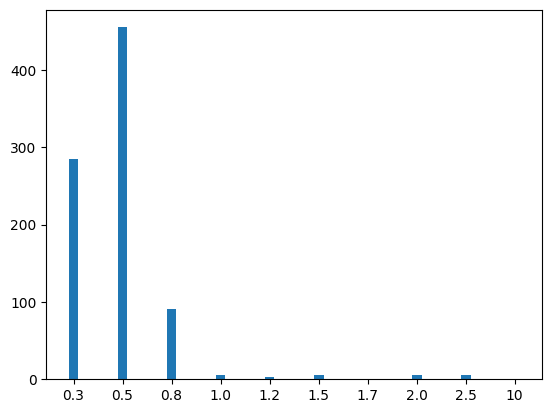

In [17]:
trs = [0.3, 0.5, 0.8, 1.0, 1.2, 1.5, 1.7, 2.0, 2.5, 10]
cnt_list = [0] * len(trs)
for sn in sn_list:
    for i in range(len(trs)):
        if sn < trs[i]+0.1:
            cnt_list[i] += 1
            break
plt.figure(0)
plt.bar([str(item) for item in trs], cnt_list, width=0.2)

# 通过滑动窗口截取数据片段
## 创建静音片段及其标注

In [ ]:
# newdf.groupby("binlab").count()

def min2sec(t: str):
    parts = t.split(':')
    res = float(parts[-1])
    f = 60
    for i in range(len(parts)-1):
        res += int(parts[len(parts)-2-i]) * f
        f *= 60
    return res

def wav_plot(wavfile, label_list, idx=0):
    y, sr = librosa.load(BILICOUGH_ROOT + wavfile)
    print("sample rate:", sr)
    y_plt = np.array([])
    for item in label_list:
        st, en = int(min2sec(item[0])*sr), int(min2sec(item[1])*sr+1)
        print("st, en:", st, en)
        seg = y[st: en]
        y_plt = np.concatenate((y_plt, seg, np.zeros(8000)), axis=0)
    plt.figure(idx)
    plt.plot(y_plt)

In [ ]:
# 通过秒到采样点的转换，截取数据


In [ ]:
for ind, item in enumerate(metadf.itertuples()):
    print("key:{},\tcount:{}, st:{}, en:{}, {}, {}".format(ind, item[1], item[2], item[3], item[5], item[6]))

# 创建神经网络

## 注意到，频域决定类别、幅值和时长是干扰因素，因为想办法在这里入手
### 频域多用全连接而不是卷积池化
### 幅值多用normalization
### 时长采用多尺度叠加

In [13]:
a = np.array([1,2,43,])
b = np.array([5,76,8,])
c = np.array([4,8,6])
print(np.concatenate((np.array([]), a, b,c), axis=0))

[ 1.  2. 43.  5. 76.  8.  4.  8.  6.]
